Perkplatz CSV laden

In [1]:
import pandas as pd
from datetime import datetime, timedelta

import_file = "../Import/transactions_202403201540.csv"
excel_file = "/home/martin/Downloads/Auswertung Nutzungsarten Q1 2024.xlsx"

date_columns = ["drive_in_at", "drive_out_at"]
df = pd.read_csv(import_file, parse_dates=date_columns)
df.head()

,gate_id_in,drive_in_at,drive_out_at,duration,id,kind
0,68,2024-01-01 05:54:08,2024-01-01 15:41:13,587,3371593,D/Y
1,68,2024-01-01 06:03:44,2024-01-01 06:08:09,5,3371607,K
2,68,2024-01-01 07:56:45,2024-01-01 11:48:14,232,3371761,D/Y
3,68,2024-01-01 09:20:34,2024-01-01 09:25:12,5,3371881,K
4,68,2024-01-01 09:49:06,2024-01-01 11:35:33,106,3371931,D/Y


In [8]:
excel_columns = ['#','Schranke ein','Einfahrt','Ausfahrt','Dauer','id','Art']
date_columns = ["Einfahrt", "Ausfahrt"]

df = pd.read_excel(excel_file, usecols=excel_columns, parse_dates=date_columns)
df.head()

,#,Schranke ein,Einfahrt,Ausfahrt,Dauer,id,Art
0,1,68,2024-01-01 05:54:08,2024-01-01 15:41:13,587.0,3.371.593,D/Y
1,2,68,2024-01-01 06:03:44,2024-01-01 06:08:09,5.0,3.371.607,K
2,3,68,2024-01-01 07:56:45,2024-01-01 11:48:14,232.0,3.371.761,D/Y
3,4,68,2024-01-01 09:20:34,2024-01-01 09:25:12,5.0,3.371.881,K
4,5,68,2024-01-01 09:49:06,2024-01-01 11:35:33,106.0,3.371.931,D/Y


In [10]:
df.rename(columns={
    'Schranke ein': 'gate_id_in', 
    'Einfahrt': 'drive_in_at',
    }, inplace=True)
df.head()

,#,gate_id_in,Einfahrt,Ausfahrt,Dauer,id,Art
0,1,68,2024-01-01 05:54:08,2024-01-01 15:41:13,587.0,3.371.593,D/Y
1,2,68,2024-01-01 06:03:44,2024-01-01 06:08:09,5.0,3.371.607,K
2,3,68,2024-01-01 07:56:45,2024-01-01 11:48:14,232.0,3.371.761,D/Y
3,4,68,2024-01-01 09:20:34,2024-01-01 09:25:12,5.0,3.371.881,K
4,5,68,2024-01-01 09:49:06,2024-01-01 11:35:33,106.0,3.371.931,D/Y


Wetterdaten laden

In [4]:
df_weather = pd.read_csv("../Import/wetter.csv", parse_dates=['date'])
df_weather.head()

,date,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
0,2024-01-01,3.6,2.1,6.6,NaN,NaN,14,4.0,13.0,1015.5,NaN
1,2024-01-02,3.0,0.7,5.7,NaN,NaN,240,7.1,18.5,1010.9,NaN
2,2024-01-03,5.7,4.2,8.3,NaN,NaN,234,5.3,14.8,1004.6,NaN
3,2024-01-04,5.2,3.9,7.9,NaN,NaN,226,4.5,14.8,1008.4,NaN
4,2024-01-05,4.0,2.1,7.2,NaN,NaN,263,5.2,16.7,1008.5,NaN


Welche Parkplatz IDs gibt es?

In [35]:
df['gate_id_in'].drop_duplicates()

0        68
17091    70
23252    72
29646    78
Name: gate_id_in, dtype: int64

IDs der Parkplätze

In [36]:
KAISERVILLA = {
    'name': "Kaiservilla",
    'gate_id': 68
}
RECHENSTEG = {
    'name': "Rechensteg",
    'gate_id': 70
}
TRAUNKAI = {
    'name': "Traunkai",
    'gate_id': 72
}
KONGRESS = {
    'name': "Kongress",
    'gate_id': 78
}

PARKING_LOTS = [KAISERVILLA, RECHENSTEG, TRAUNKAI, KONGRESS]

In [37]:
ts_start = df['drive_in_at'].min()
ts_end = df['drive_out_at'].max()

print("Data available from", ts_start, "to", ts_end)

Data available from 2024-01-01 00:26:12 to 2024-03-12 18:53:53


In [38]:
def round_to_nearest_hour(date):
    if date.minute >= 30:
        # add an hour and remove mins and secs
        return date + timedelta(hours=1) - timedelta(minutes=date.minute, seconds=date.second)
    else:
        # remove mins and secs
        return date - timedelta(minutes=date.minute, seconds=date.second)


def get_data_by_hour(data):

    # key: the_hout, value: {delta, counter}
    data_by_hour = {}
    
    start = round_to_nearest_hour(data['drive_in_at'].min())
    end = round_to_nearest_hour(data['drive_out_at'].max())
    
    # better hourly timeline

    # going in
    for index, row in data.iterrows():
        hour = round_to_nearest_hour(row["drive_in_at"])
        if not hour in data_by_hour:
            data_by_hour[hour] = {
                'delta': 0,
                'counter': 0
            }
        data_by_hour[hour]['delta'] = data_by_hour[hour]['delta'] + 1
        #print("In", row["drive_in_at"], "around", hour, data_by_hour[hour])
        
    #going out
    for index, row in data.iterrows():
        hour = round_to_nearest_hour(row["drive_out_at"])
        if not hour in data_by_hour:
            data_by_hour[hour] = {
                'delta': 0,
                'counter': 0
            }
        data_by_hour[hour]['delta'] = data_by_hour[hour]['delta'] - 1
        #print("Out", row["drive_out_at"], "around", hour, data_by_hour[hour])
        
    
    # add empty windows for smooth x axis
    current_timestamp = start.replace(minute=0, second=0, microsecond=0)
    end_timestamp = end.replace(minute=0, second=0, microsecond=0)

    while current_timestamp < end_timestamp:
        #print(current_timestamp)
        current_timestamp += timedelta(hours=1)
        if not current_timestamp in data_by_hour:
            data_by_hour[current_timestamp] = {
                'delta': 0,
                'counter': 0
            }
    
        
    # sort by date
    data_by_hour = dict(sorted(data_by_hour.items()))

    # sliding window counter algo
    current_count = 0
    for key in data_by_hour:
        current_count = current_count + data_by_hour[key]['delta']
        data_by_hour[key]['counter'] = current_count
        
    return data_by_hour


#get_data_by_hour(df)

In [40]:
import matplotlib.pyplot as plt

def plot(df, start_date, end_date, parking_lots):
    
    filtered_df = df[ df['drive_in_at'].between(start_date, end_date) ]
    
    fig, ax = plt.subplots(figsize=(14, 10))  # Create a figure containing a single axes.
    ax.set_title(f"Auslastung Parklätze {start_date} bis {end_date}")
    ax.set_xlabel('Zeit')
    ax.set_ylabel('Anzahl der Stehzeuge')
    
    #for data in [p_kaiservilla, p_kongress]
    for parking_lot in parking_lots:
        #print(parking_lot)
        p_data = filtered_df[filtered_df['gate_id_in'] == parking_lot['gate_id']]
        
        for kind in ['K', "D/Y", "D/M", "P"]:
            #print(kind)
            p_data_by_kind = p_data[ p_data['kind'] == kind ]
            
            data = get_data_by_hour(p_data_by_kind)
            x = []
            y = []
            for key in data:
                if start_date < key < end_date:
                    #print(key, data[key])
                    x.append(key)
                    y.append(data[key]['counter'])
                    
            ax.plot(x, y, label=f"{parking_lot['name']}: Typ {kind}")
    
    ax.legend()


# Parkplätze nach Typ

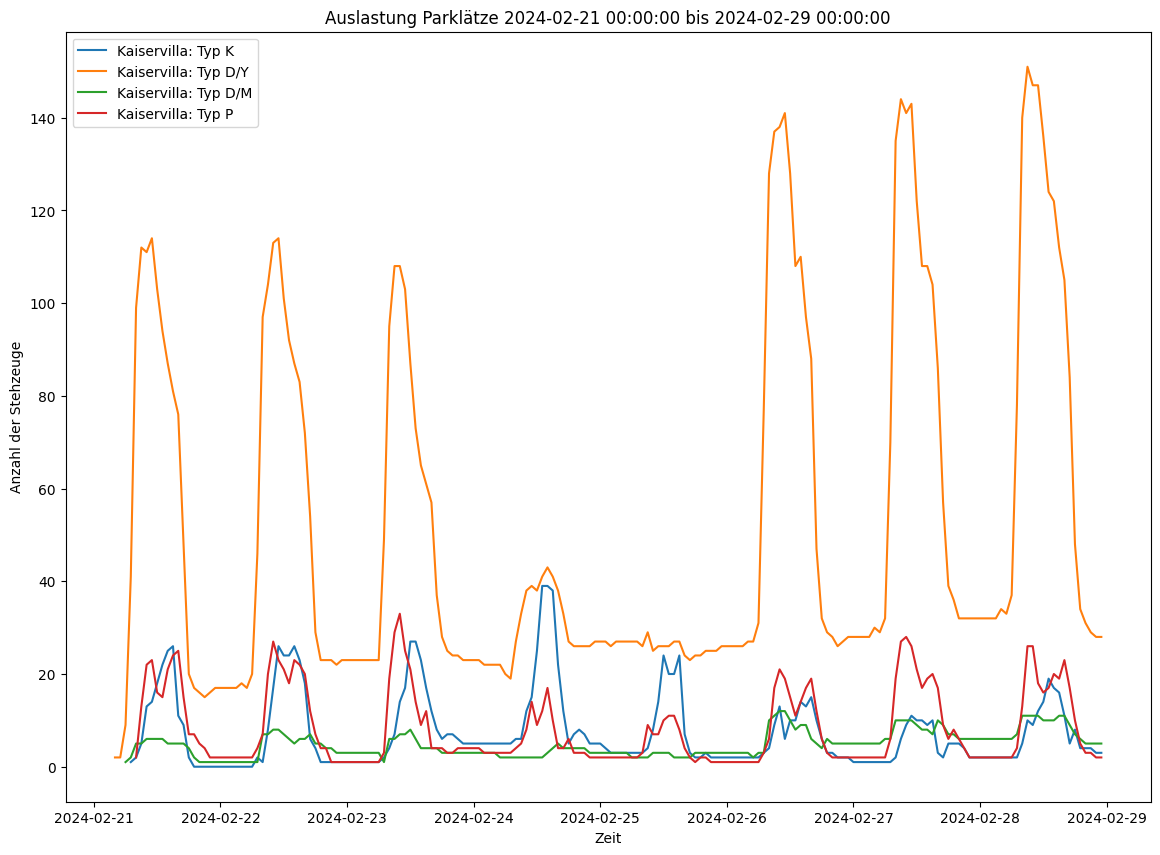

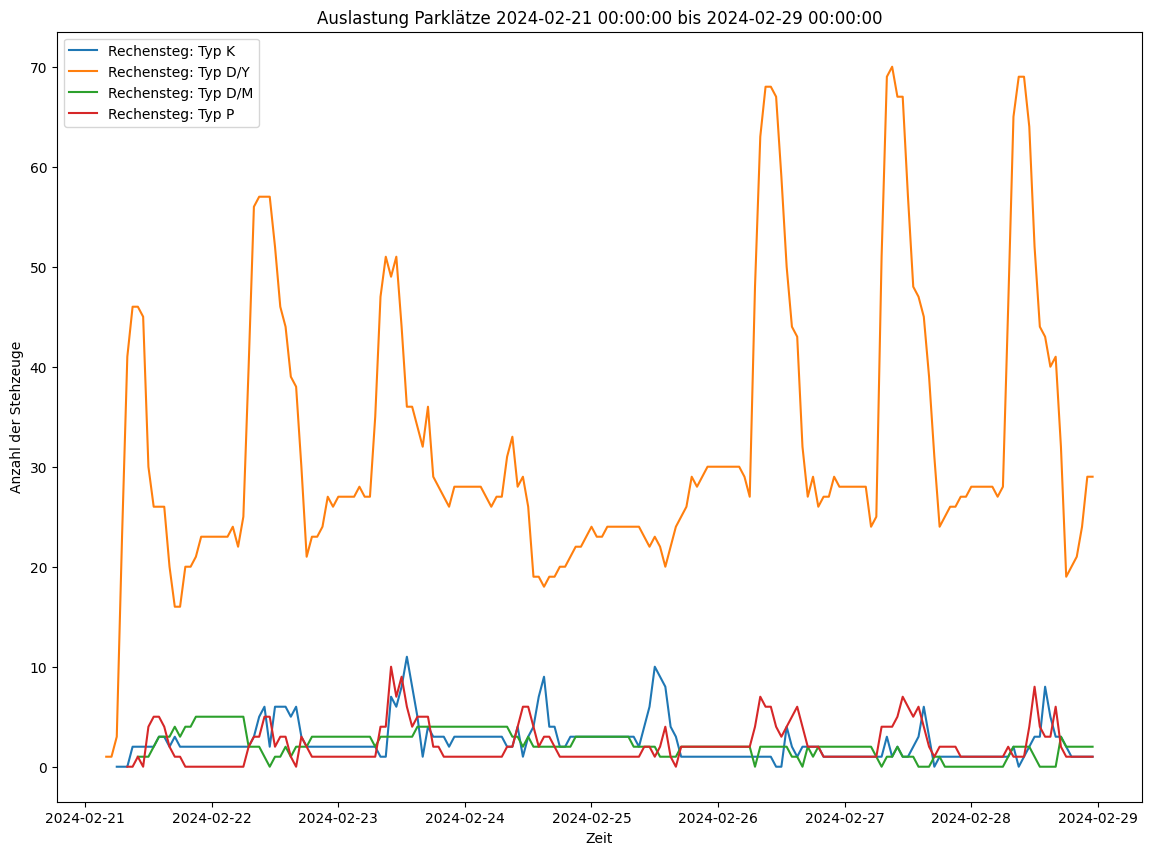

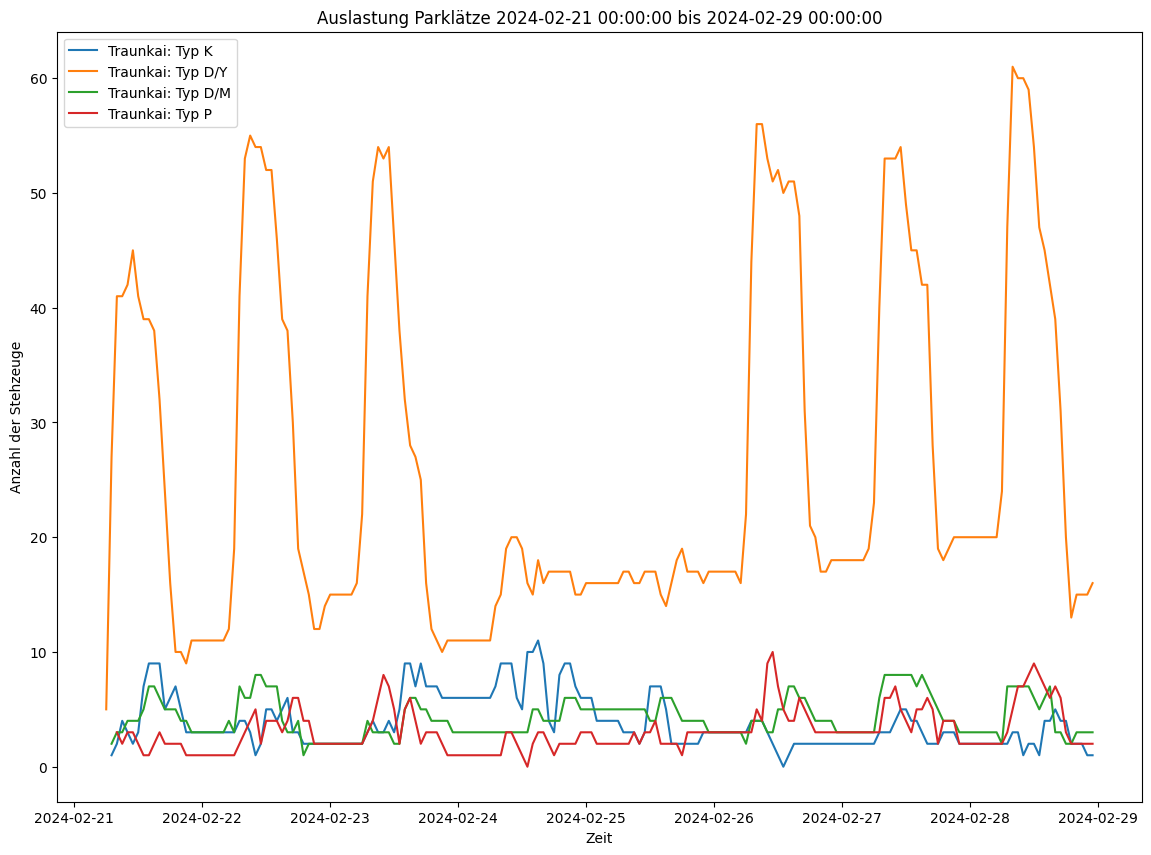

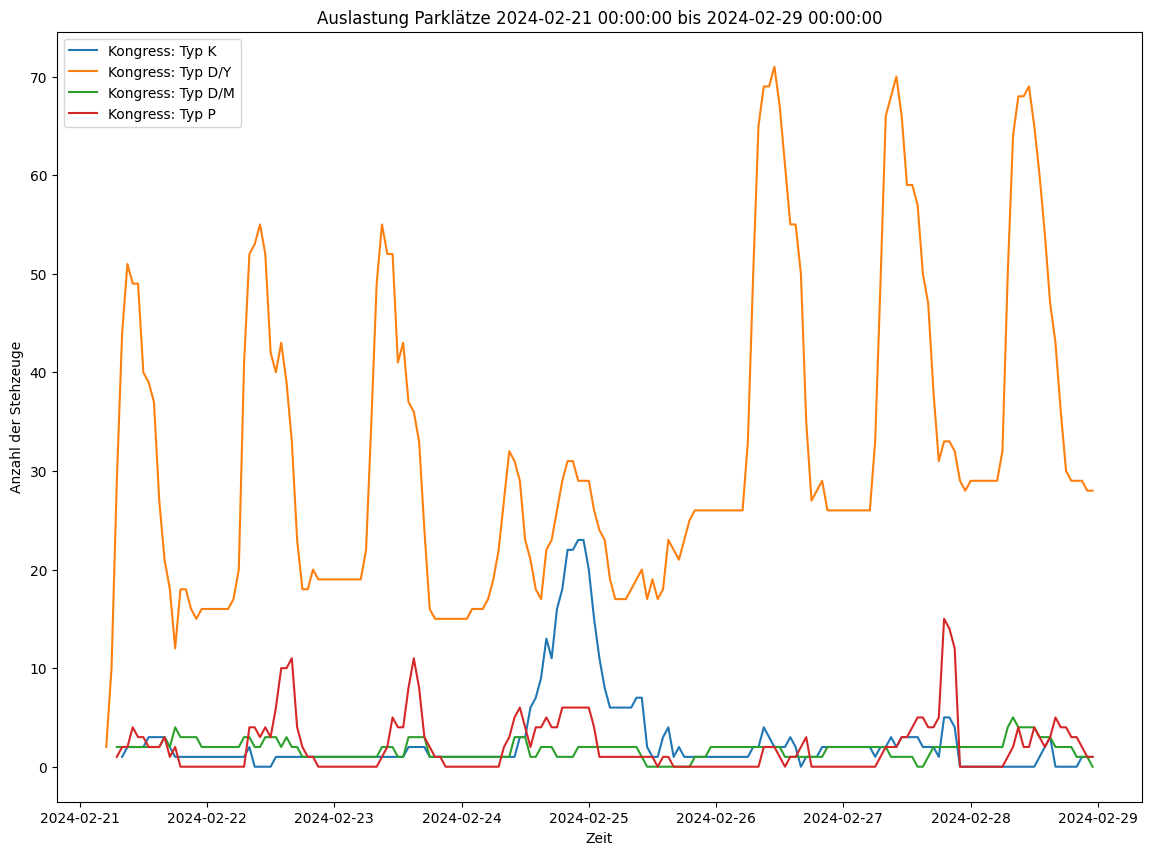

In [41]:
start_date = datetime(2024, 2, 21)
end_date = datetime(2024, 2, 29)


for p in PARKING_LOTS:
    plot(df, start_date, end_date, [p])